In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
print(os.listdir("./cell_images"))

['.DS_Store', 'Parasitized', 'Uninfected']


Using TensorFlow backend.


In [2]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [3]:
infected = os.listdir('./cell_images/Parasitized/') 
uninfected = os.listdir('./cell_images/Uninfected/')

In [4]:
data=[]
labels=[]
#load images
def loadImages(path):
    image_files= os.listdir(path)
    return image_files

#Data Preprocessing
def preprocessing(path):
    image_files=loadImages(path)
    print(len(image_files))
    for i in image_files:
        try:
            image = cv2.imread(path +i)
            image_array = Image.fromarray(image , 'RGB')
            resize_img = image_array.resize((50 , 50))
            rotated45 = resize_img.rotate(45)
            rotated75 = resize_img.rotate(75)
            blur = cv2.blur(np.array(resize_img) ,(10,10))
            #Uncomment to do segmentation
            #gray_img= cv2.cvtColor(blur,cv2.COLOR_RGB2GRAY)
            #ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            #Append labels 0 for uninfected; 1 for infected
            if "Uninfected" in path:
                labels.append(0)
            else: 
                labels.append(1)
            data.append(np.array(rotated75))
        except AttributeError:
            print('aa')   
    return data

In [5]:
image_path_uninfected="./cell_images/Uninfected/"
image_path_parasitized="./cell_images/Parasitized/"
imageArrayUninfected= preprocessing(image_path_uninfected)
imageArrayTotal= preprocessing(image_path_parasitized)

13780
aa
13780
aa


In [42]:
len(imageArrayTotal)

27558

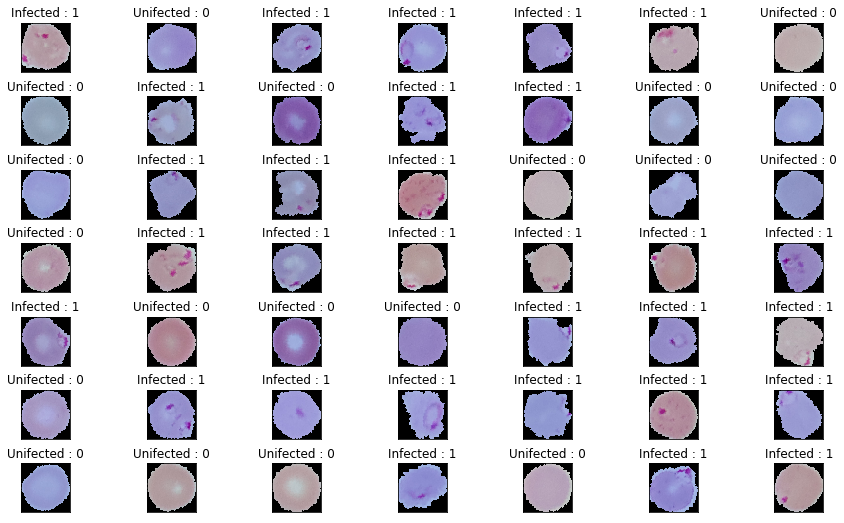

In [6]:
#Convert to np array
cells = np.array(data)
labels = np.array(labels)
np.save('Cells' , cells)
np.save('Labels' , labels)

plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

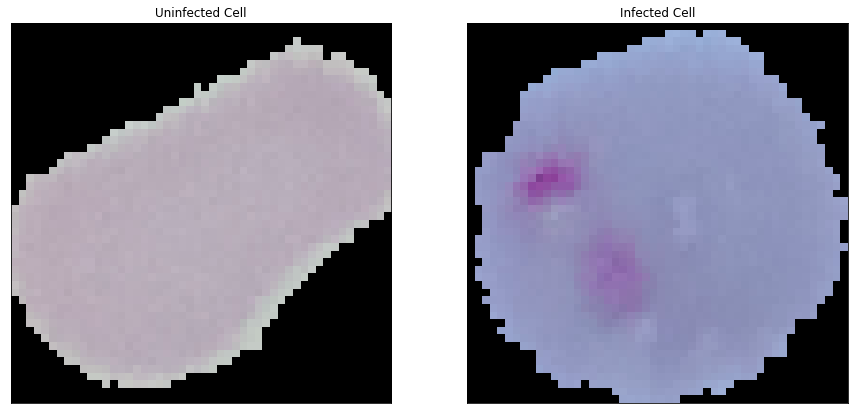

In [7]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[1])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[26000])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

In [8]:
#Shuffle the dataset
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

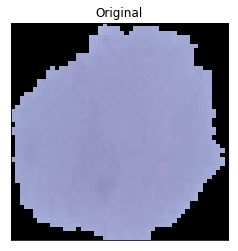

In [26]:
display_one(cells[100])

In [9]:
from sklearn.model_selection import train_test_split

x_train , x , y_train , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

x_eval , x_test , y_eval , y_test = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

In [10]:
num_classes=len(np.unique(labels))
len_data=len(cells)

In [11]:
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [40]:
y_train[1000]

array([1., 0.], dtype=float32)

In [12]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxP

In [13]:
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
#Fit the model with min batch size as 50[can tune batch size to some factor of 2^power ] 
model.fit(x_train,y_train,batch_size=50,epochs=1,verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
22046/22046 [==============================] - 45s 2ms/step - loss: 0.4780 - acc: 0.7568


In [15]:
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

2756/2756 [==============================] - 2s 591us/step

 Test_Accuracy:- 0.9285195936139332
